In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [3]:
# ------------------------------
# 1. Generate synthetic time series
# ------------------------------
np.random.seed(42)
time = np.arange(0, 300, 1)
trend = time * 0.05
seasonal = 10 * np.sin(time * 2 * np.pi / 30)
noise = np.random.normal(0, 2, len(time))
anomalies = np.where((time % 50 == 0), np.random.normal(20, 5, len(time)), 0)
series = trend + seasonal + noise + anomalies

df = pd.DataFrame({"time": time, "value": series})

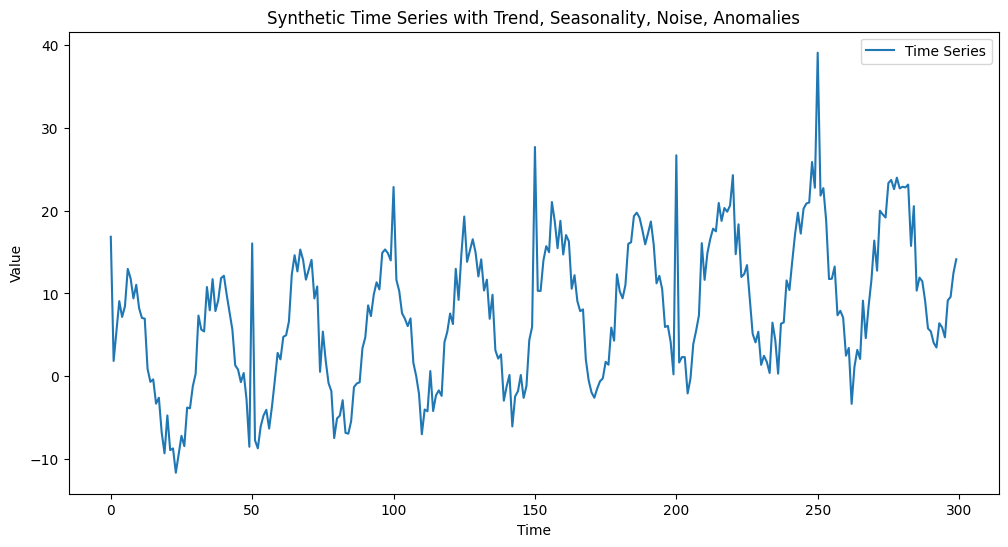

In [4]:
# ------------------------------
# 2. Visualizations
# ------------------------------
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["value"], label="Time Series")
plt.title("Synthetic Time Series with Trend, Seasonality, Noise, Anomalies")
plt.xlabel("Time"); plt.ylabel("Value"); plt.legend(); plt.show()

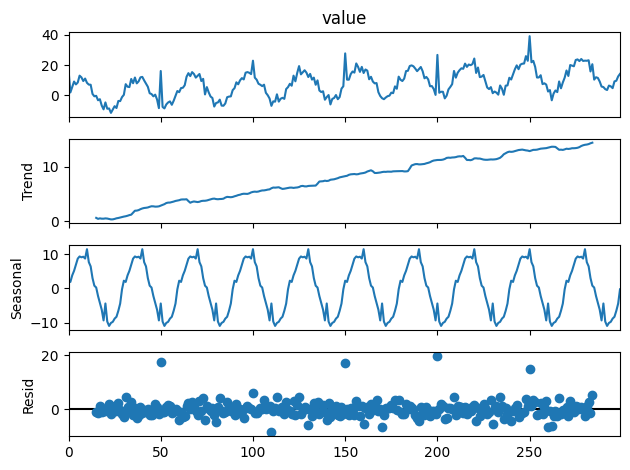

In [5]:
# Seasonal Decomposition
result = seasonal_decompose(df["value"], model="additive", period=30)
result.plot(); plt.show()

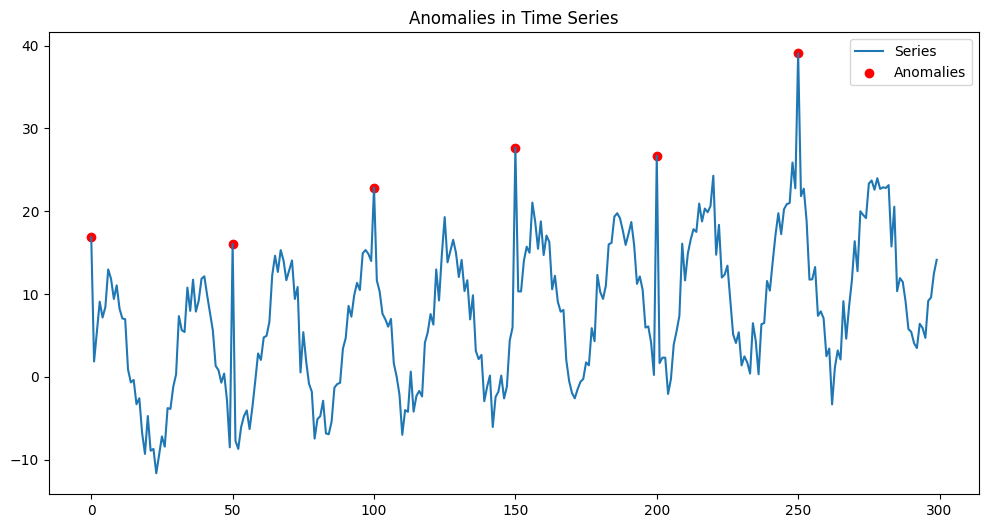

In [6]:
# Highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["value"], label="Series")
plt.scatter(df["time"][anomalies != 0], df["value"][anomalies != 0],
            color="red", label="Anomalies")
plt.legend(); plt.title("Anomalies in Time Series"); plt.show()

In [7]:
# ------------------------------
# 3. Data preparation for PyTorch
# ------------------------------
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(df[["value"]])

def create_sequences(data, seq_length=20):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

X, y = create_sequences(scaled_series, 20)
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [8]:
# ------------------------------
# 4. LSTM Model
# ------------------------------
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [9]:
# ------------------------------
# 5. Training
# ------------------------------
for epoch in range(20):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad(); loss.backward(); optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 5, Loss: 0.0343
Epoch 10, Loss: 0.0358
Epoch 15, Loss: 0.0307
Epoch 20, Loss: 0.0254


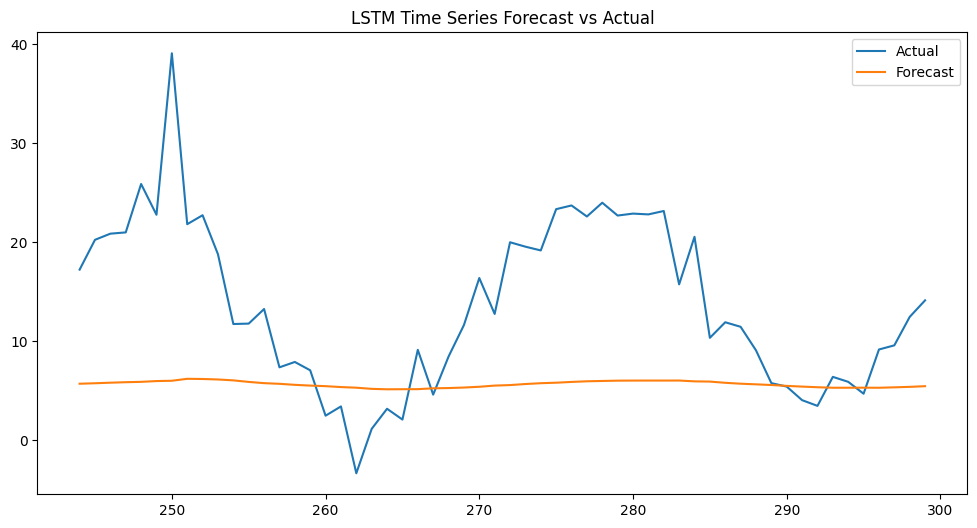

In [10]:
# ------------------------------
# 6. Forecasting & Visualization
# ------------------------------
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()

y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1,1))
preds_inv = scaler.inverse_transform(preds)

plt.figure(figsize=(12, 6))
plt.plot(df["time"][train_size+20:], y_test_inv, label="Actual")
plt.plot(df["time"][train_size+20:], preds_inv, label="Forecast")
plt.title("LSTM Time Series Forecast vs Actual")
plt.legend(); plt.show()


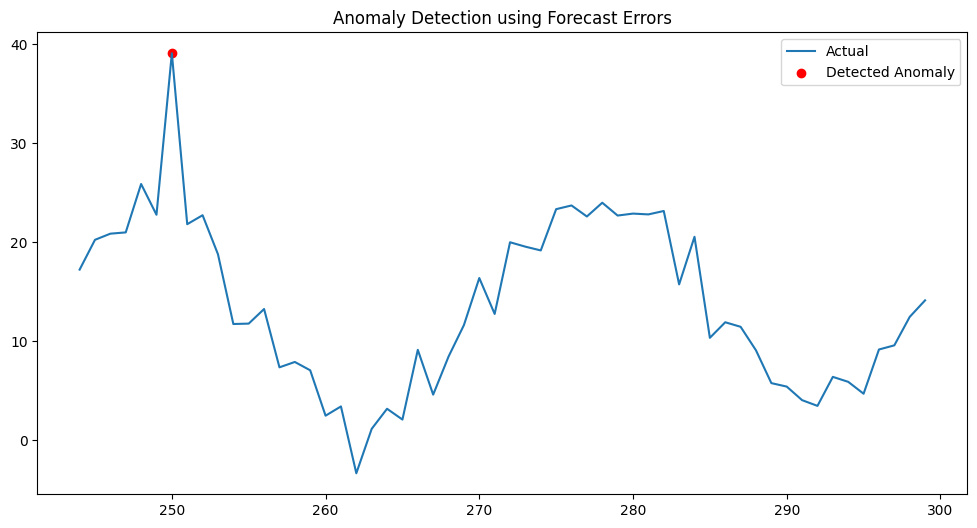

In [11]:
# ------------------------------
# 7. Anomaly Detection via Error
# ------------------------------
errors = np.abs(y_test_inv.flatten() - preds_inv.flatten())
threshold = np.mean(errors) + 2*np.std(errors)
anomaly_points = np.where(errors > threshold)[0]

plt.figure(figsize=(12,6))
plt.plot(df["time"][train_size+20:], y_test_inv, label="Actual")
plt.scatter(df["time"][train_size+20:].iloc[anomaly_points],
            y_test_inv[anomaly_points], color="red", label="Detected Anomaly")
plt.title("Anomaly Detection using Forecast Errors")
plt.legend(); plt.show()
